In [ ]:
# This reads in
# 1. FITS header information
# 2. FFT information about the PSF
# ... in order to figure out whether a Fizeau PSF consists of
# well-overlapped Airy PSFs that are stable other than phase diversity

# created 2018 Nov 26 by E.S.

In [1]:
# Import stuff

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.io import fits
import pandas as pd
from datetime import datetime
%matplotlib inline

In [2]:
stem = ('/home/../../media/unasemaje/Elements/lbti_data_reduction/'+
        '180507_fizeau_altair/05_centered/')

In [3]:
# Read in the metadata file of FITS header information

fits_table = pd.read_csv('fizeau_altair_180507_metadata.csv')

# sort table by frame number (a few are out of order)
fits_table.sort_values(["FRAMENUM"], inplace=True)
fits_table = fits_table.reset_index(drop=True) # reset indices and don't keep the old ones

/home/unasemaje/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (13,80,81,84,88,92,149) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Read in the PSF FFT information

fft_table = pd.read_csv('fizeau_altair_180507_psf_fft_info.csv')

In [5]:
# apply cutoffs and generate list of frame numbers that pass

In [6]:
# FITs keys cutoffs:

# ["PCCLOSED"]==1
# ["LLOOPON"]==1
# ["RLOOPON"]==1
# ["ACTEXP"]=="145976"
# ["LMIR_FW1"]=="94800"
# ["LMIR_FW2"]=="ND1.0-T10"
# ["LMIRFW25"]=="Lspec2.8-4.0" OR "Open" (may have to keep these filters distinct later)
# ["LMIR_FW3"]=="Open"
# ["LMIR_FW4"]=="Br-Alpha-On"

winnowed_frames_fitsKey = fits_table.index[(fits_table["PCCLOSED"] == 1) & 
                                   (fits_table["LLOOPON"] == 1) &
                                   (fits_table["RLOOPON"] == 1) &
                                   (fits_table["ACTEXP"] == 145976) &
                                   (fits_table["LMIR_FW1"] == "94800") &
                                   (fits_table["LMIR_FW2"] == "ND1.0-T10") &
                                   (np.logical_or(fits_table["LMIRFW25"] == "Lspec2.8-4.0",
                                                  fits_table["LMIRFW25"] == "Open")) &
                                   (fits_table["LMIR_FW3"] == "Open") &
                                   (fits_table["LMIR_FW4"] == "Br-Alpha-On")]



# (may have to keep these filters in FW 2.5 distinct later)

In [7]:
# FFT info cutoffs:

# amplitude of high-freq node of FFT amplitude > 20000
# (i.e., close to center of coherence envelope)

fft_table.rename(columns={'framenum':'FRAMENUM'}, inplace=True) # rename column for merger later
winnowed_frames_fftInfo = fft_table.index[(fft_table["ampl_med_highFreqPerfect_R"] > 2.4e5)]

In [8]:
# find the overlapping frame numbers between the list of frames 
# winnowed by FITS key values, and FFT high-freq power

In [9]:
# rows containing frames of interest: fits_table.loc[winnowed_frames_fitsKey]
# actual frame numbers corresponding to those rows: fits_table.loc[winnowed_frames_fitsKey]["FRAMENUM"]

# extract frame info for shared frames
frameInfo_from_fitsKey = fits_table.loc[winnowed_frames_fitsKey]
frameInfo_from_fftInfo = fft_table.loc[winnowed_frames_fftInfo]

# extract the frame numbers alone (just FYI for now)
framenums_from_fitsKey = fits_table.loc[winnowed_frames_fitsKey]["FRAMENUM"].reset_index()
framenums_from_fftInfo = fft_table.loc[winnowed_frames_fftInfo]["FRAMENUM"].reset_index()

In [10]:
# find the shared frame numbers and merge the tables based on those
frames_shared = pd.merge(frameInfo_from_fitsKey, frameInfo_from_fftInfo, how="inner", on=["FRAMENUM"])

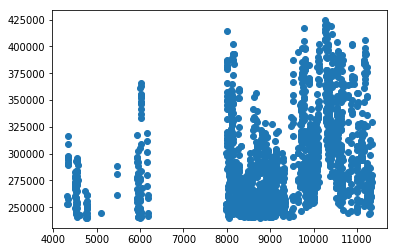

In [11]:
# TESTING ONLY

plt.scatter(frames_shared.loc[:]["FRAMENUM"],frames_shared.loc[:]["ampl_med_highFreqPerfect_R"])
#plt.xlim([5000,6000])
plt.show()

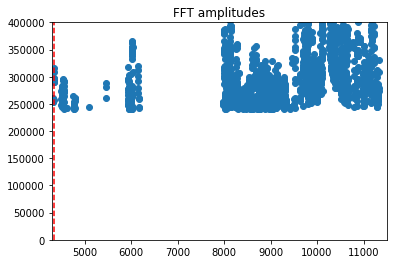

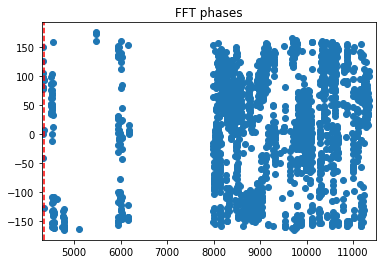

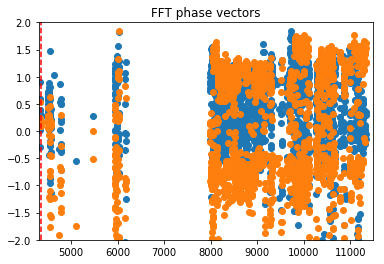

In [62]:
# TESTING ONLY

xlim_array = [4300,11500]
x_mark = 4351

plt.title('FFT amplitudes')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["ampl_med_highFreqPerfect_R"])
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["ampl_med_lowFreqPerfect"])
plt.xlim(xlim_array)
plt.ylim([0,400000])
plt.axvline(x=x_mark, linestyle='--', color='red')
plt.show()

plt.title('FFT phases')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_med_highFreqPerfect_R"])
#plt.scatter(frames_shared.loc[:]["FRAMENUM"],
#            frames_shared.loc[:]["phase_med_lowFreqPerfect"])
plt.xlim(xlim_array)
plt.axvline(x=x_mark, linestyle='--', color='red')
plt.show()

plt.title('FFT phase vectors')
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_x"])
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_y"])
'''
plt.scatter(frames_shared.loc[:]["FRAMENUM"],
            np.sqrt(np.add(
                np.power(
                    frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_x"],
                    2
                ),
                np.power(
                    frames_shared.loc[:]["phase_normVec_highFreqPerfect_R_y"],
                    2
                )
            )))
'''
plt.xlim(xlim_array)
plt.ylim([-2,2])
plt.axvline(x=x_mark, linestyle='--', color='red')
plt.show()

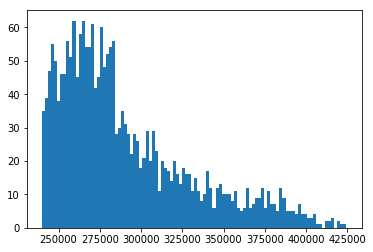

In [12]:
# TESTING ONLY

plt.hist(frames_shared.loc[:]["ampl_med_highFreqPerfect_R"], bins=100)
plt.show()

In [13]:
# TESTING ONLY

N = 5
print(frames_shared.loc[10]["FRAMENUM"])
print(frames_shared.loc[10]["ampl_med_highFreqPerfect_R"])

4342
296601.58522895235


In [14]:
# TESTING ONLY

len(frames_shared)

2113

In [15]:
# loop over all the 'good' frames and copy them to a directory along with a png

for goodFrame in range(0,len(frames_shared)):
    
    # read in frame
    frameNum = frames_shared["FRAMENUM"][goodFrame]
    filename = 'lm_180507_'+str("{:0>6d}".format(frameNum))+'_nPCA164.fits'
    image, header = fits.getdata(stem + filename, 0, header=True)
    
    # write out PNG
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(image, origin="lower")
    fig.suptitle('Frame '+str("{:0>6d}".format(frameNum)))
    fig.savefig(stem + '../06_winnowed/pngs/' + \
                'lm_180507_'+str("{:0>6d}".format(frameNum))+'.png', overwrite=True)
    fig.clf()
    plt.close()
    del(fig)

    # write out FITS frame
    hdul = fits.PrimaryHDU(image, header=header)
    hdul.writeto(stem + '../06_winnowed/' + filename, overwrite=True)
    
    print('Frame '+str("{:0>6d}".format(frameNum))+' written...')

Frame 004327 written...
Frame 004331 written...
Frame 004332 written...
Frame 004335 written...
Frame 004336 written...
Frame 004337 written...
Frame 004338 written...
Frame 004339 written...
Frame 004340 written...
Frame 004341 written...
Frame 004342 written...
Frame 004343 written...
Frame 004344 written...
Frame 004351 written...
Frame 004503 written...
Frame 004504 written...
Frame 004505 written...
Frame 004506 written...
Frame 004507 written...
Frame 004508 written...
Frame 004509 written...
Frame 004510 written...
Frame 004511 written...
Frame 004512 written...
Frame 004513 written...
Frame 004514 written...
Frame 004515 written...
Frame 004516 written...
Frame 004517 written...
Frame 004518 written...
Frame 004519 written...
Frame 004520 written...
Frame 004521 written...
Frame 004522 written...
Frame 004524 written...
Frame 004525 written...
Frame 004526 written...
Frame 004527 written...
Frame 004528 written...
Frame 004529 written...
Frame 004530 written...
Frame 004531 wri

Frame 008173 written...
Frame 008174 written...
Frame 008175 written...
Frame 008176 written...
Frame 008179 written...
Frame 008180 written...
Frame 008181 written...
Frame 008182 written...
Frame 008183 written...
Frame 008184 written...
Frame 008185 written...
Frame 008186 written...
Frame 008187 written...
Frame 008188 written...
Frame 008189 written...
Frame 008190 written...
Frame 008191 written...
Frame 008192 written...
Frame 008193 written...
Frame 008194 written...
Frame 008195 written...
Frame 008196 written...
Frame 008197 written...
Frame 008198 written...
Frame 008199 written...
Frame 008200 written...
Frame 008201 written...
Frame 008202 written...
Frame 008203 written...
Frame 008204 written...
Frame 008205 written...
Frame 008206 written...
Frame 008207 written...
Frame 008208 written...
Frame 008209 written...
Frame 008210 written...
Frame 008211 written...
Frame 008212 written...
Frame 008213 written...
Frame 008214 written...
Frame 008215 written...
Frame 008216 wri

Frame 008582 written...
Frame 008583 written...
Frame 008584 written...
Frame 008585 written...
Frame 008586 written...
Frame 008587 written...
Frame 008588 written...
Frame 008589 written...
Frame 008590 written...
Frame 008593 written...
Frame 008594 written...
Frame 008595 written...
Frame 008596 written...
Frame 008597 written...
Frame 008598 written...
Frame 008601 written...
Frame 008623 written...
Frame 008625 written...
Frame 008626 written...
Frame 008627 written...
Frame 008628 written...
Frame 008629 written...
Frame 008630 written...
Frame 008631 written...
Frame 008633 written...
Frame 008634 written...
Frame 008635 written...
Frame 008636 written...
Frame 008637 written...
Frame 008638 written...
Frame 008639 written...
Frame 008640 written...
Frame 008677 written...
Frame 008678 written...
Frame 008679 written...
Frame 008680 written...
Frame 008681 written...
Frame 008682 written...
Frame 008683 written...
Frame 008684 written...
Frame 008685 written...
Frame 008686 wri

Frame 009140 written...
Frame 009141 written...
Frame 009142 written...
Frame 009143 written...
Frame 009144 written...
Frame 009145 written...
Frame 009146 written...
Frame 009147 written...
Frame 009148 written...
Frame 009149 written...
Frame 009150 written...
Frame 009151 written...
Frame 009152 written...
Frame 009153 written...
Frame 009154 written...
Frame 009155 written...
Frame 009156 written...
Frame 009157 written...
Frame 009158 written...
Frame 009159 written...
Frame 009160 written...
Frame 009161 written...
Frame 009162 written...
Frame 009163 written...
Frame 009164 written...
Frame 009165 written...
Frame 009166 written...
Frame 009167 written...
Frame 009168 written...
Frame 009170 written...
Frame 009171 written...
Frame 009173 written...
Frame 009175 written...
Frame 009270 written...
Frame 009271 written...
Frame 009272 written...
Frame 009273 written...
Frame 009274 written...
Frame 009275 written...
Frame 009276 written...
Frame 009277 written...
Frame 009278 wri

Frame 009945 written...
Frame 009946 written...
Frame 009947 written...
Frame 009948 written...
Frame 009949 written...
Frame 009950 written...
Frame 009951 written...
Frame 009952 written...
Frame 009953 written...
Frame 009954 written...
Frame 009955 written...
Frame 009956 written...
Frame 009957 written...
Frame 009958 written...
Frame 009959 written...
Frame 009960 written...
Frame 009961 written...
Frame 009962 written...
Frame 009963 written...
Frame 009964 written...
Frame 009965 written...
Frame 009966 written...
Frame 009967 written...
Frame 009968 written...
Frame 009969 written...
Frame 009970 written...
Frame 009971 written...
Frame 009972 written...
Frame 009973 written...
Frame 009974 written...
Frame 009975 written...
Frame 009976 written...
Frame 009977 written...
Frame 009978 written...
Frame 009979 written...
Frame 009980 written...
Frame 009981 written...
Frame 009982 written...
Frame 009983 written...
Frame 009984 written...
Frame 009985 written...
Frame 009986 wri

Frame 010542 written...
Frame 010543 written...
Frame 010544 written...
Frame 010545 written...
Frame 010546 written...
Frame 010547 written...
Frame 010548 written...
Frame 010549 written...
Frame 010550 written...
Frame 010551 written...
Frame 010552 written...
Frame 010553 written...
Frame 010554 written...
Frame 010555 written...
Frame 010556 written...
Frame 010557 written...
Frame 010558 written...
Frame 010559 written...
Frame 010560 written...
Frame 010561 written...
Frame 010562 written...
Frame 010563 written...
Frame 010564 written...
Frame 010565 written...
Frame 010566 written...
Frame 010567 written...
Frame 010568 written...
Frame 010569 written...
Frame 010570 written...
Frame 010571 written...
Frame 010572 written...
Frame 010573 written...
Frame 010574 written...
Frame 010575 written...
Frame 010576 written...
Frame 010577 written...
Frame 010578 written...
Frame 010579 written...
Frame 010580 written...
Frame 010581 written...
Frame 010582 written...
Frame 010583 wri

KeyboardInterrupt: 